In [1]:
from model import Qwen2VLForConditionalGeneration, Qwen2VLProcessor, Qwen2VLImageProcessor
from qwen_vl_utils import process_vision_info
import torch
from PIL import Image

In [2]:
device = 'cuda:0'

model_path = "/home/syc/intern/wanshan/Qwen2VL-Resampler-Finetune/output/resampler_7b_retain_ratio_1"

In [3]:
# retain ratio 
retain_ratio = 0.9

model = Qwen2VLForConditionalGeneration.from_pretrained(
    model_path,
    device_map=device,
    attn_implementation="flash_attention_2",
    torch_dtype=torch.bfloat16,
    retain_ratio=retain_ratio
)


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [7]:
min_pixel = 256*28*28
max_pixel = 1280*28*28


processor = Qwen2VLProcessor.from_pretrained(model_path, use_fast=False, min_pixels = min_pixel, max_pixels = max_pixel)


messages = [
{
    "role": "user",
    "content": [
        {
            "type": "image",
            "image": "/data/data1/syc/intern/wanshan/datasets/ScreenSpot/screenspot_imgs/mobile_1ca5b944-293a-46a1-af95-eb35bc8a0b2a.png",
            
        },
        {"type": "text", "text": "open facetime app"},
    ],
}
]

text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
).to(device)



In [8]:
_, select_mask = model.visual(inputs['pixel_values'], inputs['image_grid_thw']) 

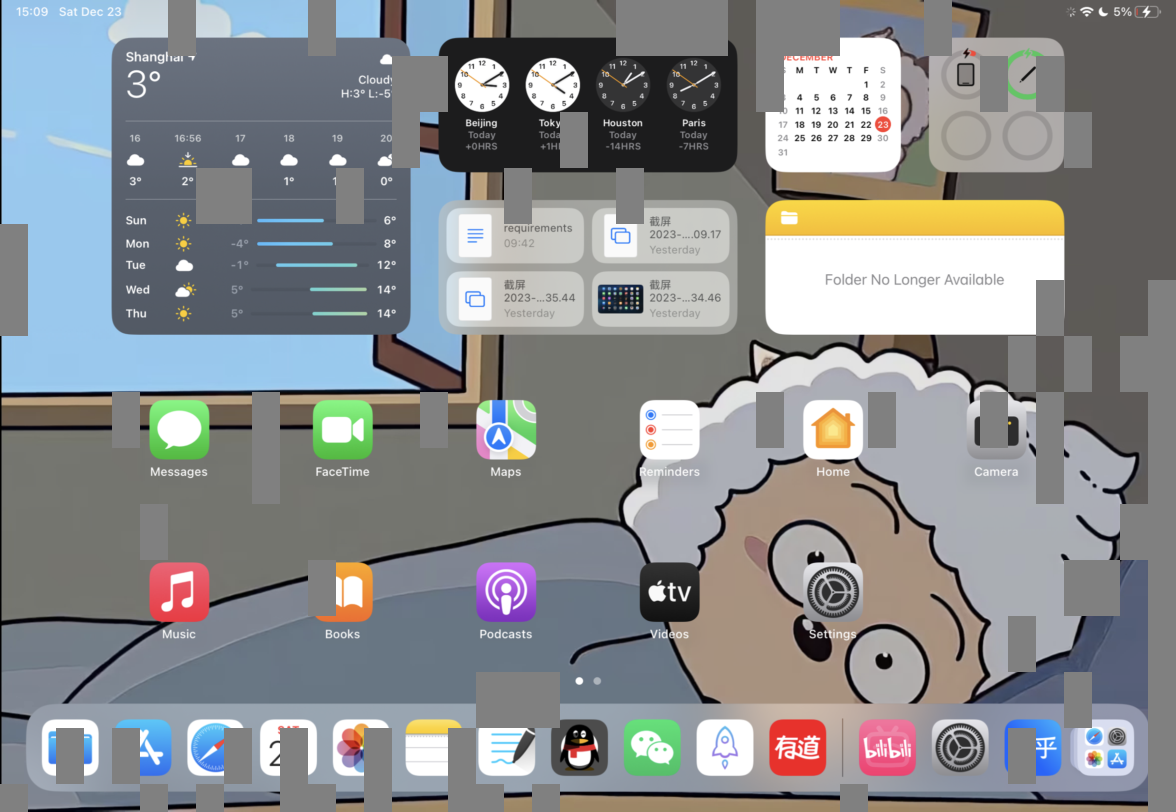

In [9]:
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
    select_mask=select_mask.cpu().numpy(),
    vis_dir="./visualize_imgs"
).to(device)

# show image 
img = Image.open("./visualize_imgs/demo.png")
img